In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = np.concatenate((x_train, x_test), axis = 0).astype(np.float32)
x_train = x_train / 255.
x_train.shape

(70000, 28, 28)

In [3]:
x_train_gan = x_train.reshape(-1, 28, 28, 1) * 2 - 1.

In [4]:
codings = 128
batch_size = 64
n_epochs = 2000

dm = keras.models.Sequential([
    keras.layers.Conv2D(64, 9, strides = 2, padding = "same", activation = "selu", kernel_initializer = "lecun_normal", input_shape = [28, 28 ,1]),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, 5, strides = 2, padding = "same", activation = "selu", kernel_initializer = "lecun_normal"),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation = "selu", kernel_initializer = "lecun_normal"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation = "sigmoid"),
])

gn = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape = [codings]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, 9, strides = 2, padding = "same", activation = "selu", kernel_initializer = "lecun_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, 7, strides = 2, padding = "same", activation = "tanh")
])

In [5]:
gan = keras.models.Sequential([gn, dm])

In [6]:
dm.compile(loss = "binary_crossentropy", optimizer = "nadam")
dm.trainable = False
gan.compile(loss = "binary_crossentropy", optimizer = "nadam")

In [7]:
dataset = tf.data.Dataset.from_tensor_slices(x_train_gan).shuffle(100000)
dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)

In [8]:
def display_images(images, number_per_row = 6, number_per_column = 1):
    plt.figure(figsize = (2 * number_per_row, 2 * number_per_column))
    for i in range(number_per_row * number_per_column):
        plt.subplot(number_per_column, number_per_row, i + 1)
        plt.imshow((images[i] + 1) / 2,  cmap = "binary")
        plt.axis("off")
    plt.show()

In [9]:
def train_gan(gan, dataset, batch_size = batch_size, epochs = n_epochs, codings = codings):
    gn, dm = gan.layers
    for epoch in range(epochs):
        for x_batch in dataset:
            #training the discriminator
            noise = tf.random.normal(shape = [batch_size, codings])
            generated_images = gn(noise)
            data = tf.concat([generated_images, x_batch], axis = 0)
            labels = tf.concat([[0.] * batch_size , [1.] * batch_size], axis = 0)[..., np.newaxis]
            dm.trainable = True
            dm.train_on_batch(data, labels)
            
            #training the generator
            noise = tf.random.normal(shape = [batch_size, codings])
            labels = tf.constant([[1.]] * batch_size)
            dm.trainable = False
            gan.train_on_batch(noise, labels)
        if (epoch + 1) % 400 == 0:
            print("Epoch {}/{}".format(epoch + 1, epochs))
            display_images(generated_images)

Epoch 400/2000


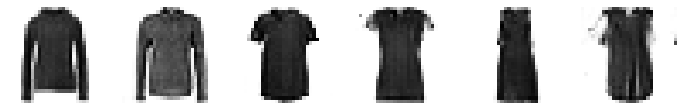

Epoch 800/2000


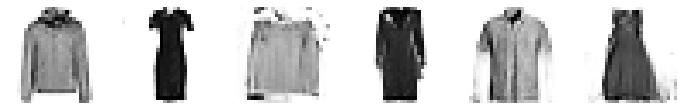

Epoch 1200/2000


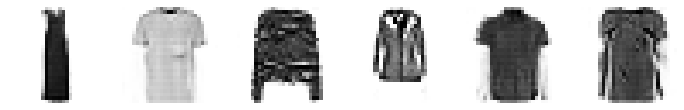

Epoch 1600/2000


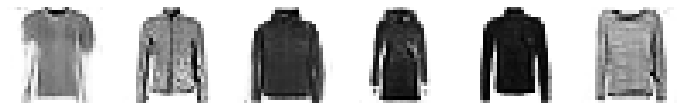

Epoch 2000/2000


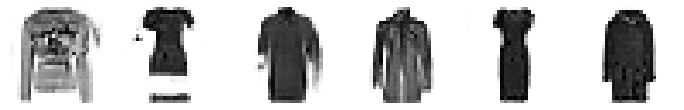

In [10]:
train_gan(gan, dataset)

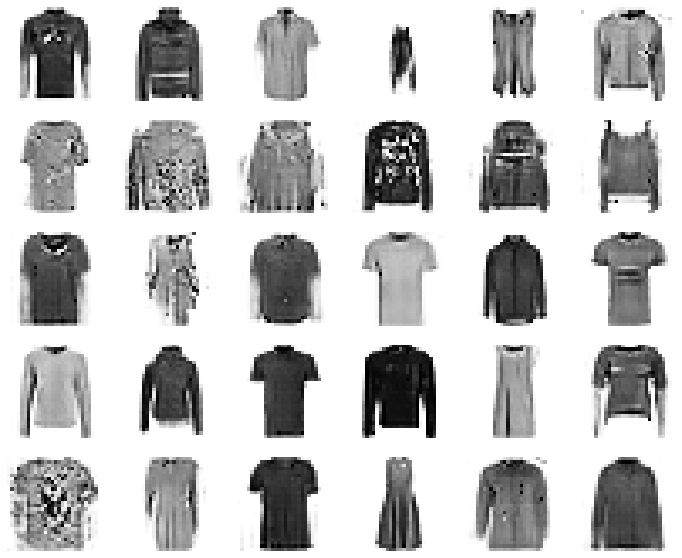

In [11]:
noise = tf.random.normal(shape = [30, codings])
images = gn(noise)
display_images(images, number_per_row = 6, number_per_column = 5)